This notebook explains why the LightGBM model makes specific predictions by analyzing how features affect the model's decisions.

**Model Features:**
- **Categorical (3):** sector, size, industry
- **Numeric (10):** momentum, lagged_return, marketcap, pb, asset_growth, roe, gp_to_assets, grossmargin, assetturnover, leverage

In [ ]:
!pip install shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12

### 1. Load Model and Data and Make Predictions

In [88]:
# Load the trained model
model_data = joblib.load('lightGBM.pkl')
model = model_data['model']
label_encoders = model_data['label_encoders']
feature_cols = model_data['feature_cols']
categorical_features = model_data['categorical_features']
numeric_features = model_data['numeric_features']
print(f"Model loaded: {type(model).__name__}")
print(f"Number of estimators: {model.n_estimators}")
print(f"Features: {len(feature_cols)} total ({len(categorical_features)} categorical + {len(numeric_features)} numeric)")

# Load current data and features
df = pd.read_excel('currentdata.xlsx')
print(f"Data shape: {df.shape}")
print(f"Month: {df['month'].iloc[0]}")
print(f"Number of stocks: {len(df)}")

# Make predictions
X = df[feature_cols]
df['predict'] = model.predict(X)
#print(f"Predictions generated for {len(df)} stocks")
print(f"Prediction range: [{df['predict'].min():.4f}, {df['predict'].max():.4f}]")

Model loaded: LGBMRegressor
Number of estimators: 100
Features: 13 total (3 categorical + 10 numeric)
Data shape: (2910, 15)
Month: 2025-10
Number of stocks: 2910
Prediction range: [0.2532, 0.5854]


In [92]:
df.head()

,ticker,month,sector,size,industry,momentum,lagged_return,marketcap,pb,asset_growth,roe,gp_to_assets,grossmargin,assetturnover,leverage,predict
0,A,2025-10,6,0,35,0.246048,0.648282,0.901375,0.801375,0.725258,0.808935,0.681787,0.524055,0.562027,0.348797,0.525379
1,AA,2025-10,0,0,5,0.237457,0.642268,0.739519,0.377320,0.331443,0.312371,0.369588,0.082818,0.714433,0.532990,0.503201
2,AAL,2025-10,7,0,3,0.673711,0.036598,0.716151,0.046392,0.277491,0.173540,0.862543,0.524055,0.723711,0.932646,0.516419
3,AAMI,2025-10,5,3,8,0.945704,0.252577,0.444330,0.956873,0.799485,0.993814,0.952921,0.910481,0.729210,0.824055,0.505160
4,AAOI,2025-10,9,3,25,0.909278,0.790722,0.435052,0.701546,0.926460,0.060997,0.332131,0.182131,0.571649,0.455670,0.495895


#### Size Category Analysis

Analyzing how predictions vary by market cap size categories.

In [91]:
# Comprehensive size analysis
size_order = ['Mega-Cap', 'Large-Cap', 'Mid-Cap', 'Small-Cap', 'Micro-Cap', 'Nano-Cap']
size_analysis = df.groupby('size').agg({
    'predict': ['mean', 'median', 'std', 'min', 'max'],
    'ticker': 'count'
}).round(4)
size_analysis.columns = ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Count']

# Reorder by size
size_analysis = size_analysis.reindex([s for s in size_order if s in size_analysis.index])

print("PREDICTION STATISTICS BY SIZE")
print("="*80)
print(size_analysis)

# Analyze size effect
print("\n" + "="*80)
print("SIZE CATEGORY INSIGHTS")
print("="*80)
for size in size_analysis.index:
    row = size_analysis.loc[size]
    vs_overall = (row['Mean'] - df['predict'].mean()) * 100
    direction = "above" if vs_overall > 0 else "below"
    print(f"\n{size}:")
    print(f"  Mean prediction: {row['Mean']*100:.3f}% ({abs(vs_overall):.3f}% {direction} overall mean)")
    print(f"  Number of stocks: {int(row['Count'])}")
    print(f"  Prediction range: {row['Min']*100:.3f}% to {row['Max']*100:.3f}%")

PREDICTION STATISTICS BY SIZE
Empty DataFrame
Columns: [Mean, Median, Std Dev, Min, Max, Count]
Index: []

SIZE CATEGORY INSIGHTS


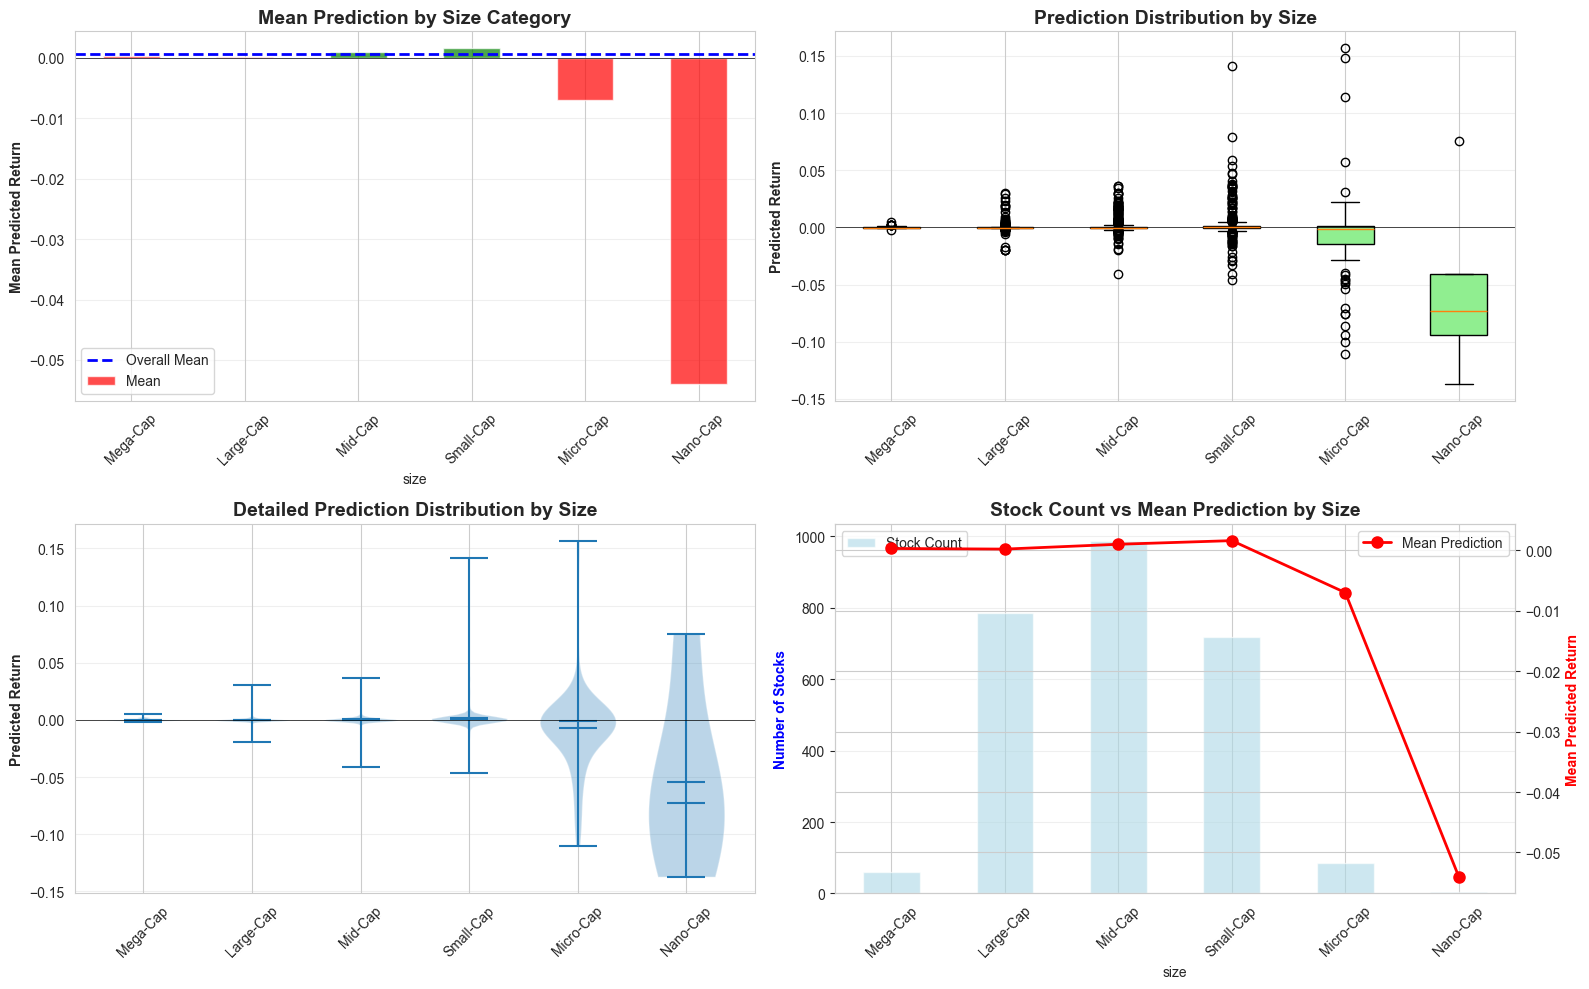

In [ ]:
# Visualize size category effects
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Mean predictions by size
ax = axes[0, 0]
colors_size = ['green' if x > df['predict'].mean() else 'red' for x in size_analysis['Mean']]
size_analysis['Mean'].plot(kind='bar', ax=ax, color=colors_size, alpha=0.7)
ax.axhline(y=df['predict'].mean(), color='blue', linestyle='--', linewidth=2, label='Overall Mean')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Mean Predicted Return', fontweight='bold')
ax.set_title('Mean Prediction by Size Category', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Plot 2: Prediction distributions by size
ax = axes[0, 1]
size_data = [df[df['size'] == s]['predict'].values for s in size_analysis.index]
bp = ax.boxplot(size_data, labels=size_analysis.index, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Predicted Return', fontweight='bold')
ax.set_title('Prediction Distribution by Size', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)

# Plot 3: Violin plot for detailed distribution
ax = axes[1, 0]
size_df_plot = df[df['size'].isin(size_analysis.index)].copy()
# Ensure proper ordering
size_df_plot['size'] = pd.Categorical(size_df_plot['size'], categories=size_analysis.index, ordered=True)
positions = range(len(size_analysis.index))
parts = ax.violinplot([df[df['size'] == s]['predict'].values for s in size_analysis.index],
                       positions=positions, widths=0.7, showmeans=True, showmedians=True)
ax.set_xticks(positions)
ax.set_xticklabels(size_analysis.index, rotation=45)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Predicted Return', fontweight='bold')
ax.set_title('Detailed Prediction Distribution by Size', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Plot 4: Count and mean together
ax = axes[1, 1]
ax2 = ax.twinx()
size_analysis['Count'].plot(kind='bar', ax=ax, color='lightblue', alpha=0.6, label='Stock Count')
size_analysis['Mean'].plot(kind='line', ax=ax2, color='red', marker='o', linewidth=2, markersize=8, label='Mean Prediction')
ax.set_ylabel('Number of Stocks', fontweight='bold', color='blue')
ax2.set_ylabel('Mean Predicted Return', fontweight='bold', color='red')
ax.set_title('Stock Count vs Mean Prediction by Size', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### Industry Analysis

Analyzing predictions across different industries (more granular than sectors).

In [ ]:
# Comprehensive industry analysis
industry_analysis = df.groupby('industry').agg({
    'predict': ['mean', 'median', 'std', 'count']
}).round(4)
industry_analysis.columns = ['Mean', 'Median', 'Std Dev', 'Count']
industry_analysis = industry_analysis.sort_values('Mean', ascending=False)

print(f"Total number of industries: {len(industry_analysis)}")
print("\n" + "="*80)
print("TOP 20 INDUSTRIES BY MEAN PREDICTION")
print("="*80)
print(industry_analysis.head(20))

print("\n" + "="*80)
print("BOTTOM 20 INDUSTRIES BY MEAN PREDICTION")
print("="*80)
print(industry_analysis.tail(20))

# Statistics
print("\n" + "="*80)
print("INDUSTRY STATISTICS")
print("="*80)
print(f"Industry with highest mean prediction: {industry_analysis.index[0]}")
print(f"  Mean: {industry_analysis.iloc[0]['Mean']*100:.3f}%, Count: {int(industry_analysis.iloc[0]['Count'])}")
print(f"\nIndustry with lowest mean prediction: {industry_analysis.index[-1]}")
print(f"  Mean: {industry_analysis.iloc[-1]['Mean']*100:.3f}%, Count: {int(industry_analysis.iloc[-1]['Count'])}")
print(f"\nIndustries with >50 stocks:")
large_industries = industry_analysis[industry_analysis['Count'] > 50]
print(f"  Count: {len(large_industries)}")
for ind in large_industries.index[:5]:
    print(f"  - {ind}: {large_industries.loc[ind, 'Mean']*100:.3f}% (n={int(large_industries.loc[ind, 'Count'])})")

Total number of industries: 143

TOP 20 INDUSTRIES BY MEAN PREDICTION
                                    Mean  Median  Std Dev  Count
industry                                                        
Airports & Air Services           0.0125  0.0125   0.0185      2
Biotechnology                     0.0099  0.0052   0.0234    158
Medical Devices                   0.0029 -0.0002   0.0254     57
Gold                              0.0029  0.0002   0.0068      6
Mortgage Finance                  0.0027  0.0006   0.0065     11
Computer Hardware                 0.0026  0.0005   0.0087     13
Oil & Gas E&P                     0.0023 -0.0005   0.0239     43
Capital Markets                   0.0022  0.0005   0.0145     33
Department Stores                 0.0019 -0.0002   0.0039      3
Electronic Gaming & Multimedia    0.0017  0.0014   0.0018      4
Airlines                          0.0017 -0.0002   0.0055      8
Agricultural Inputs               0.0017  0.0008   0.0025      6
Banks - Regional    

KeyError: 'predict'

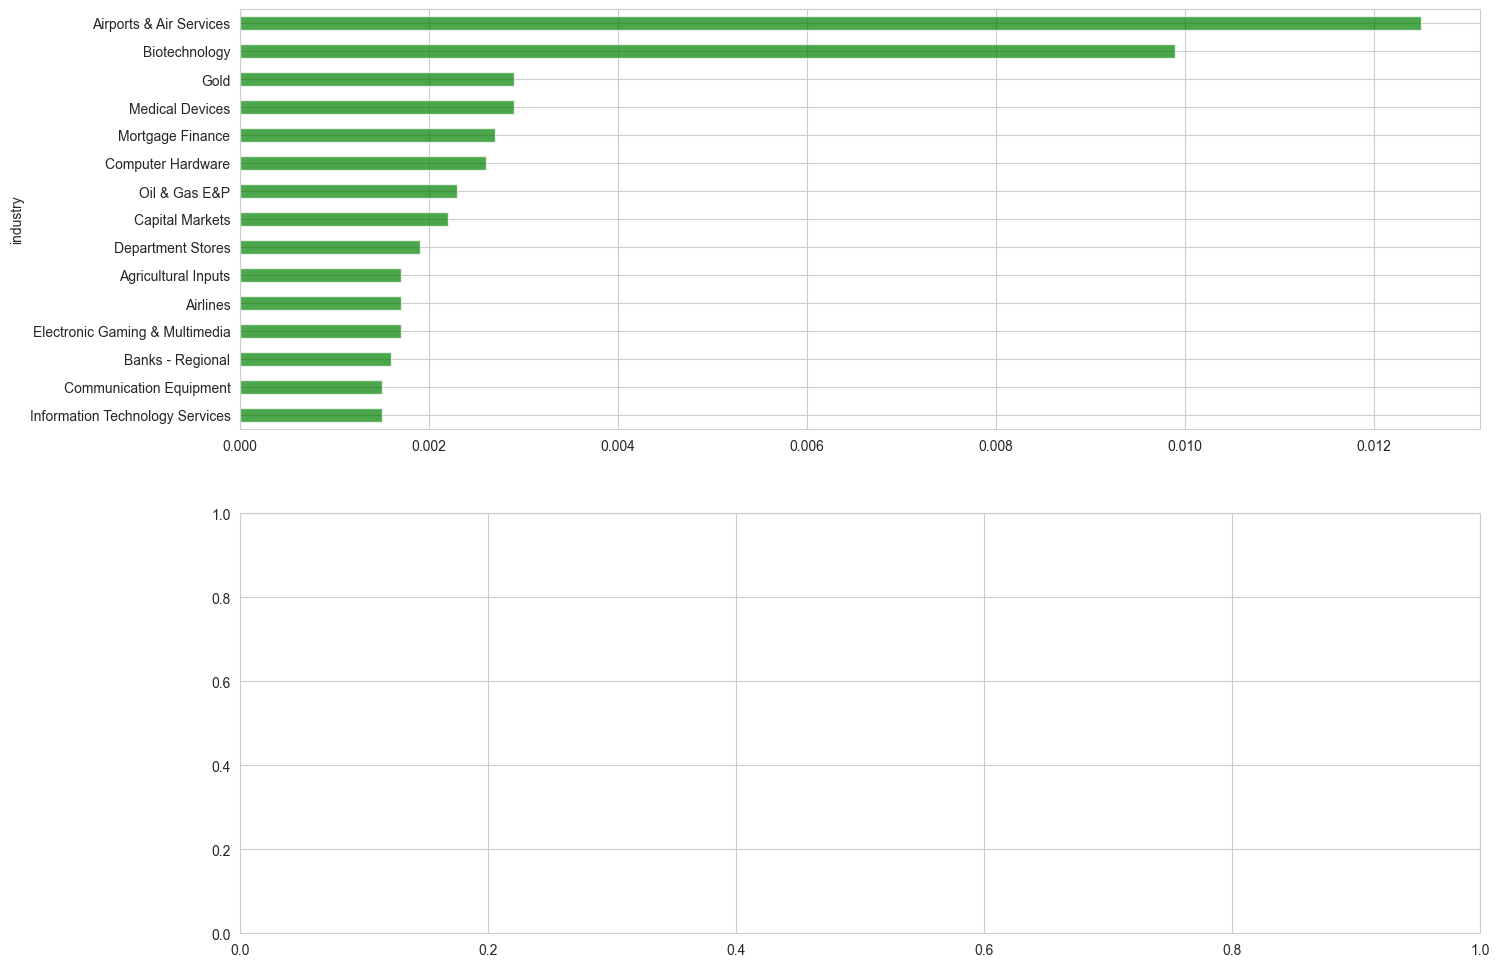

In [85]:
# Visualize industry effects (top and bottom industries)
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Top 15 industries by mean prediction
ax = axes[0]
top_15_ind = industry_analysis.head(15)['Mean'].sort_values(ascending=True)
colors_ind = ['green'] * len(top_15_ind)
top_15_ind.plot(kind='barh', ax=ax, color=colors_ind, alpha=0.7)
ax.axvline(x=df['predict'].mean(), color='blue', linestyle='--', linewidth=2, label='Overall Mean')
ax.set_xlabel('Mean Predicted Return', fontweight='bold')
ax.set_title('Top 15 Industries by Mean Prediction', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Plot 2: Bottom 15 industries by mean prediction
ax = axes[1]
bottom_15_ind = industry_analysis.tail(15)['Mean'].sort_values(ascending=True)
colors_ind = ['red'] * len(bottom_15_ind)
bottom_15_ind.plot(kind='barh', ax=ax, color=colors_ind, alpha=0.7)
ax.axvline(x=df['predict'].mean(), color='blue', linestyle='--', linewidth=2, label='Overall Mean')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Mean Predicted Return', fontweight='bold')
ax.set_title('Bottom 15 Industries by Mean Prediction', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)



plt.tight_layout()
plt.show()

#### Continuous Features Overview

Now let's examine the numeric features and their relationship with predictions.

In [ ]:
# Analyze continuous features
# Get numeric features from loaded model
numeric_features = model_data['numeric_features']
print(f"Numeric features: {numeric_features}")

# Calculate correlations with predictions
feature_correlations = pd.DataFrame({
    'feature': numeric_features,
    'correlation': [df[feat].corr(df['predict']) for feat in numeric_features]
}).sort_values('correlation', key=abs, ascending=False)

print("CONTINUOUS FEATURES: CORRELATION WITH PREDICTIONS")
print("="*80)
print(feature_correlations.to_string(index=False))

# Statistics for top and bottom deciles
print("\n" + "="*80)
print("CONTINUOUS FEATURES: TOP vs BOTTOM DECILE")
print("="*80)

# Use simple quartile-based approach instead of qcut
df_sorted = df.sort_values('predict')
n = len(df_sorted)
bottom_20pct = df_sorted.head(int(n * 0.2))
top_20pct = df_sorted.tail(int(n * 0.2))

comparison = pd.DataFrame({
    'Feature': numeric_features,
    'Bottom_20%': [bottom_20pct[f].mean() for f in numeric_features],
    'Top_20%': [top_20pct[f].mean() for f in numeric_features],
})
comparison['Difference'] = comparison['Top_20%'] - comparison['Bottom_20%']
comparison = comparison.sort_values('Difference', key=abs, ascending=False)

print("\nMean values in top 20% vs bottom 20% of predictions:")
print(comparison.to_string(index=False))

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)
print(f"\nTop 3 features distinguishing high vs low predictions:")
for i, row in comparison.head(3).iterrows():
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"  • {row['Feature']}: {direction} by {abs(row['Difference']):.4f} in top 20%")

CONTINUOUS FEATURES: CORRELATION WITH PREDICTIONS
      feature  correlation
assetturnover    -0.114416
  grossmargin     0.102664
 gp_to_assets    -0.083015
    lag_month     0.076338
     lag_week     0.048297
     momentum     0.044873
     leverage    -0.030755
           pb    -0.005429
    marketcap    -0.000777
          roe     0.000454
 asset_growth     0.000277

CONTINUOUS FEATURES: TOP vs BOTTOM DECILE

Mean values in top 20% vs bottom 20% of predictions:
      Feature  Bottom_20%      Top_20%   Difference
    marketcap 6049.043750 18107.267424 12058.223674
           pb    9.533144     6.492614    -3.040530
     leverage    3.872256     6.282780     2.410525
 asset_growth    1.165524     0.224058    -0.941466
  grossmargin   -0.011267     0.803648     0.814915
assetturnover    0.686924     0.230152    -0.456773
          roe    0.220845    -0.107256    -0.328100
     momentum    0.057828     0.192518     0.134690
 gp_to_assets    0.246703     0.138782    -0.107920
    lag_m

### 3. Overall Feature Importance & SHAP Analysis

Now let's use SHAP (SHapley Additive exPlanations) to understand how ALL features - both categorical and continuous - contribute to predictions.

### 2c. Categorical Variable Interactions

How do combinations of categorical variables affect predictions? For example, does the model treat Healthcare Micro-Caps differently from Healthcare Large-Caps?

In [83]:
# Sector-Size interaction analysis
sector_size = df.groupby(['sector', 'size']).agg({
    'predict': ['mean', 'count']
}).round(4)
sector_size.columns = ['Mean_Prediction', 'Count']
sector_size = sector_size.reset_index()

# Filter to combinations with at least 10 stocks
sector_size_filtered = sector_size[sector_size['Count'] >= 10].copy()
sector_size_filtered = sector_size_filtered.sort_values('Mean_Prediction', ascending=False)

print("SECTOR-SIZE COMBINATIONS (with ≥10 stocks)")
print("="*80)
print("\nTop 20 Combinations:")
print(sector_size_filtered.head(20).to_string(index=False))

print("\n" + "="*80)
print("\nBottom 20 Combinations:")
print(sector_size_filtered.tail(20).to_string(index=False))

# Specific insights
print("\n" + "="*80)
print("SECTOR-SIZE INSIGHTS")
print("="*80)

# For each top sector, show best and worst size
top_sectors = sector_analysis.head(3).index.tolist()
for sector in top_sectors:
    sector_data = sector_size_filtered[sector_size_filtered['sector'] == sector]
    if len(sector_data) > 0:
        best_size = sector_data.nlargest(1, 'Mean_Prediction')
        worst_size = sector_data.nsmallest(1, 'Mean_Prediction')
        print(f"\n{sector}:")
        print(f"  Best: {best_size['size'].values[0]} ({best_size['Mean_Prediction'].values[0]*100:.3f}%, n={int(best_size['Count'].values[0])})")
        if len(sector_data) > 1:
            print(f"  Worst: {worst_size['size'].values[0]} ({worst_size['Mean_Prediction'].values[0]*100:.3f}%, n={int(worst_size['Count'].values[0])})")

KeyError: "Column(s) ['predict'] do not exist"

## 3. Overall Feature Importance & SHAP Analysis

Now let's use SHAP (SHapley Additive exPlanations) to understand how ALL features - both categorical and continuous - contribute to predictions.

### 3a. Prepare Features for SHAP Analysis

The model was trained with both numeric features (percentile-ranked) and categorical features (sector, size, industry). LightGBM handles categorical features natively using optimal splits.

### 3b. Calculate SHAP Values

Now that we have prepared the features, let's calculate SHAP values for all features.

In [ ]:
# Identify feature columns (model was trained ONLY on continuous features)
# Get numeric features from loaded model
numeric_features = model_data['numeric_features']
print(f"Numeric features: {numeric_features}")

print(f"Continuous features ({len(numeric_features)}):")
print(numeric_features)
print(f"\nNote: The model was trained ONLY on these {len(numeric_features)} continuous features.")
print("Categorical variables (sector, size, industry) are in the data but were NOT used in training.")

# Convert continuous features to percentile ranks (as done in training)
df_ranked = df.copy()
for col in numeric_features:
    df_ranked[col] = df[col].rank(pct=True)

# Extract feature matrix for SHAP (ONLY continuous features)
X = df_ranked[numeric_features].values
print(f"\nFeature matrix shape: {X.shape}")
print(f"This matches the model's training data: 11 features")

In [ ]:
# Create SHAP explainer with all features (including categoricals)
print("Creating SHAP explainer for full model...")
print("This may take a minute as we're analyzing all features including categorical variables...")
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a sample
sample_size = min(500, len(df))
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(df), sample_size, replace=False)
X_sample = X_with_categoricals[sample_indices]

print(f"Calculating SHAP values for {sample_size} stocks...")
shap_values = explainer.shap_values(X_sample)
print("Done!")

# Calculate average absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'mean_abs_shap': mean_abs_shap,
    'type': ['continuous']*len(continuous_features) + ['categorical']*len(categorical_features)
}).sort_values('mean_abs_shap', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE BY SHAP VALUES")
print("="*80)
print(feature_importance_df)

print("\n" + "="*80)
print("CATEGORICAL vs CONTINUOUS FEATURE IMPORTANCE")
print("="*80)
cat_importance = feature_importance_df[feature_importance_df['type'] == 'categorical']['mean_abs_shap'].sum()
cont_importance = feature_importance_df[feature_importance_df['type'] == 'continuous']['mean_abs_shap'].sum()
total_importance = cat_importance + cont_importance
print(f"Categorical features total importance: {cat_importance:.4f} ({cat_importance/total_importance*100:.1f}%)")
print(f"Continuous features total importance: {cont_importance:.4f} ({cont_importance/total_importance*100:.1f}%)")

print("\nTop 10 Most Important Features (All Types):")
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:15s} ({row['type']:11s}): SHAP = {row['mean_abs_shap']:.4f}")

Creating SHAP explainer for full model...
This may take a minute as we're analyzing all features including categorical variables...
Calculating SHAP values for 500 stocks...


LightGBMError: The number of features in data (14) is not the same as it was in training data (11).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

### 3. Feature Importance Analysis

First, let's see which features the model considers most important overall.

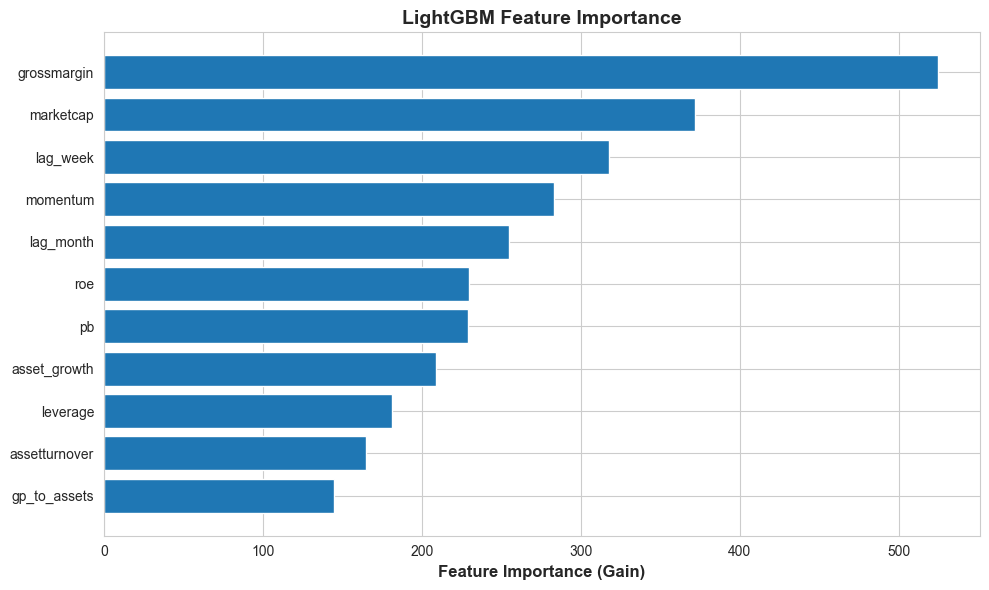


Top 5 Most Important Features:
       feature  importance
8  grossmargin         525
3    marketcap         372
1     lag_week         318
0     momentum         283
2    lag_month         255


In [ ]:
# Get feature importance from the model
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.xlabel('Feature Importance (Gain)', fontsize=12, fontweight='bold')
plt.title('LightGBM Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance.head())

### 4. Feature Deep Dives

Let's examine how specific categorical and numeric features affect predictions in detail.

#### 4a. Categorical Feature Effects

NameError: name 'feature_importance_df' is not defined

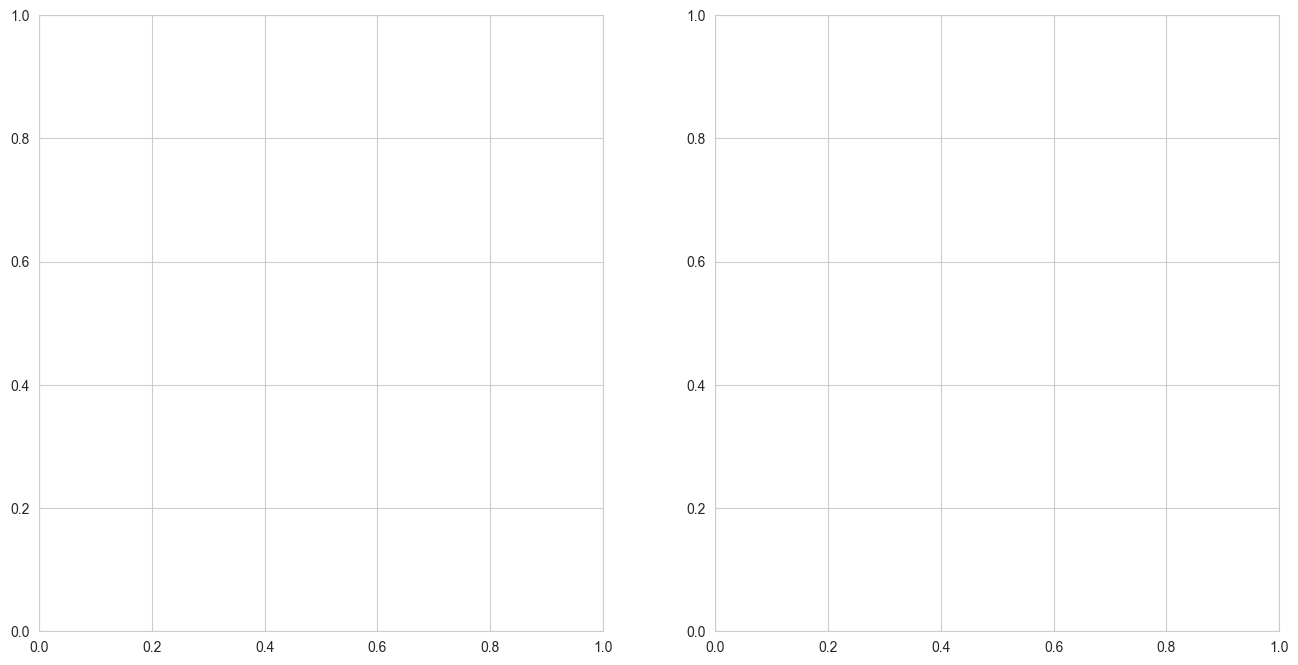

In [ ]:
# Visualize SHAP feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Bar plot of all features
ax = axes[0]
colors_feat = ['coral' if t == 'categorical' else 'steelblue' for t in feature_importance_df['type']]
feature_importance_df.plot(x='feature', y='mean_abs_shap', kind='barh', 
                           ax=ax, color=colors_feat, legend=False)
ax.set_xlabel('Mean Absolute SHAP Value', fontweight='bold')
ax.set_ylabel('')
ax.set_title('Feature Importance (SHAP) - All Features', fontsize=14, fontweight='bold')
ax.invert_yaxis()
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='coral', label='Categorical'),
                  Patch(facecolor='steelblue', label='Continuous')]
ax.legend(handles=legend_elements, loc='lower right')

# Plot 2: SHAP summary plot
ax = axes[1]
shap.summary_plot(shap_values, X_sample, feature_names=all_features, 
                  plot_type="bar", show=False, max_display=14)
plt.title('SHAP Summary - Top 14 Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Grouped bar chart comparing categorical vs continuous
fig, ax = plt.subplots(figsize=(10, 6))
cat_features = feature_importance_df[feature_importance_df['type'] == 'categorical']
cont_top = feature_importance_df[feature_importance_df['type'] == 'continuous'].head(3)
comparison_df = pd.concat([cat_features, cont_top])
comparison_df = comparison_df.sort_values('mean_abs_shap', ascending=True)
colors = ['coral' if t == 'categorical' else 'steelblue' for t in comparison_df['type']]
comparison_df.plot(x='feature', y='mean_abs_shap', kind='barh', ax=ax, color=colors, legend=False)
ax.set_xlabel('Mean Absolute SHAP Value', fontweight='bold')
ax.set_title('Categorical Features vs Top Continuous Features', fontsize=14, fontweight='bold')
legend_elements = [Patch(facecolor='coral', label='Categorical'),
                  Patch(facecolor='steelblue', label='Continuous')]
ax.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

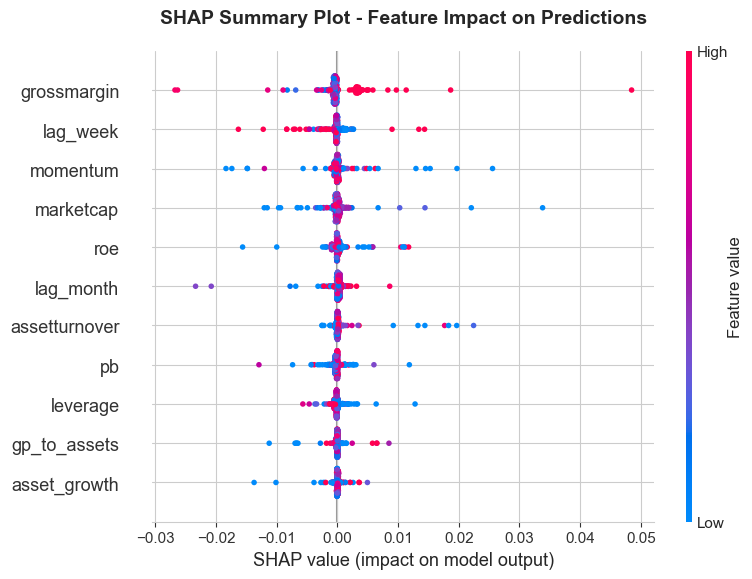

In [ ]:
# Summary plot - shows feature importance and impact direction
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### 5. Categorical Feature SHAP Analysis

Now let's analyze SHAP values specifically for categorical features to understand how individual sectors, sizes, and industries affect predictions.

#### 4b. Continuous Feature Effects via SHAP

Now let's analyze SHAP values for numeric features to understand their detailed impact on predictions.

In [ ]:
# Analyze SHAP values for continuous features
continuous_shap_importance = {}
for feat in continuous_features:
    feat_idx = all_features.index(feat)
    feat_shap = np.abs(shap_values[:, feat_idx]).mean()
    continuous_shap_importance[feat] = feat_shap

continuous_shap_df = pd.DataFrame({
    'feature': list(continuous_shap_importance.keys()),
    'mean_abs_shap': list(continuous_shap_importance.values())
}).sort_values('mean_abs_shap', ascending=False)

print("CONTINUOUS FEATURES: SHAP IMPORTANCE")
print("="*80)
print(continuous_shap_df.to_string(index=False))

# Get top 3 continuous features
top_3_continuous = continuous_shap_df.head(3)['feature'].tolist()

print("\n" + "="*80)
print("TOP 3 CONTINUOUS FEATURES (by SHAP):")
print("="*80)
for i, feat in enumerate(top_3_continuous, 1):
    shap_val = continuous_shap_df[continuous_shap_df['feature'] == feat]['mean_abs_shap'].values[0]
    corr_val = feature_correlations[feature_correlations['feature'] == feat]['correlation'].values[0]
    print(f"\n{i}. {feat.upper()}")
    print(f"   Mean |SHAP|: {shap_val:.4f}")
    print(f"   Correlation: {corr_val:.4f}")
    
    # Sample some values to show effect
    feat_idx = all_features.index(feat)
    sample_shap = shap_values[:, feat_idx]
    print(f"   SHAP range: [{sample_shap.min():.4f}, {sample_shap.max():.4f}]")
    print(f"   Avg positive effect: {sample_shap[sample_shap > 0].mean():.4f}")
    print(f"   Avg negative effect: {sample_shap[sample_shap < 0].mean():.4f}")

In [ ]:
### 5. Explaining Individual Predictions

Let's examine specific stocks to see how ALL features (categorical and continuous) contribute to their predictions.

In [ ]:
# Analyze top and bottom stocks showing ALL feature contributions
top_stocks = df.nlargest(10, 'predict')
bottom_stocks = df.nsmallest(10, 'predict')

def show_feature_breakdown(row, sample_indices, shap_values, title):
    """Show both categorical and continuous features for a stock"""
    print(f"\n{row['ticker']} - Predicted: {row['predict']*100:.2f}%")
    print(f"  Categorical: {row['sector']}, {row['size']}, {row['industry']}")
    print(f"  Key Continuous:")
    print(f"    Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")
    print(f"    Lagged Return: {row['lagged_return']*100:.2f}%, Market Cap: ${row['marketcap']/1e9:.1f}B")
    
    # Show SHAP contributions if available
    if row.name in sample_indices:
        sample_idx_in_shap = np.where(sample_indices == row.name)[0][0]
        
        # Categorical contribution
        cat_shap = (shap_values[sample_idx_in_shap, all_features.index('sector')] + 
                   shap_values[sample_idx_in_shap, all_features.index('size')] + 
                   shap_values[sample_idx_in_shap, all_features.index('industry')])
        
        # Top 3 continuous contributions
        cont_shap_vals = []
        for feat in top_3_continuous:
            feat_idx = all_features.index(feat)
            cont_shap_vals.append((feat, shap_values[sample_idx_in_shap, feat_idx]))
        
        print(f"  SHAP Contributions:")
        print(f"    Categorical (total): {cat_shap:.4f}")
        for feat, val in cont_shap_vals:
            print(f"    {feat}: {val:.4f}")

print("TOP 10 PREDICTED STOCKS - COMPLETE FEATURE ANALYSIS")
print("="*80)
for idx, row in top_stocks.iterrows():
    show_feature_breakdown(row, sample_indices, shap_values, "top")

print("\n" + "="*80)
print("BOTTOM 10 PREDICTED STOCKS - COMPLETE FEATURE ANALYSIS")
print("="*80)
for idx, row in bottom_stocks.iterrows():
    show_feature_breakdown(row, sample_indices, shap_values, "bottom")

In [ ]:
### 6. Comprehensive Summary

Bringing together all insights about how the LightGBM model uses features to make predictions.

In [ ]:
print("="*80)
print("LIGHTGBM MODEL: COMPLETE FEATURE IMPORTANCE ANALYSIS")
print("="*80)

print("\n1. OVERALL FEATURE IMPORTANCE (SHAP)")
print("-" * 80)
print("\nCategorical vs Continuous:")
print(f"  • Categorical features: {cat_importance/total_importance*100:.1f}% of total impact")
print(f"  • Continuous features: {cont_importance/total_importance*100:.1f}% of total impact")

print("\nTop 10 Most Important Features (All Types):")
for i, (_, row) in enumerate(feature_importance_df.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:15s} ({row['type']:11s}): SHAP = {row['mean_abs_shap']:.4f}")

print("\n2. CATEGORICAL FEATURES")
print("-" * 80)
cat_features_ranked = feature_importance_df[feature_importance_df['type'] == 'categorical'].sort_values('mean_abs_shap', ascending=False)
for i, (_, row) in enumerate(cat_features_ranked.iterrows(), 1):
    print(f"  {i}. {row['feature']}: SHAP = {row['mean_abs_shap']:.4f}")

print("\nKey Sector Effects (by SHAP):")
for i, (sector, row) in enumerate(sector_shap_analysis.head(2).iterrows(), 1):
    print(f"  • {sector}: +{row['mean']:.4f} (avg pred: {sector_analysis.loc[sector, 'Mean']*100:.2f}%)")
for i, (sector, row) in enumerate(sector_shap_analysis.tail(2).iterrows(), 1):
    print(f"  • {sector}: {row['mean']:.4f} (avg pred: {sector_analysis.loc[sector, 'Mean']*100:.2f}%)")

print("\n3. CONTINUOUS FEATURES")
print("-" * 80)
print("Top 5 Continuous Features (by SHAP):")
for i, (_, row) in enumerate(continuous_shap_df.head(5).iterrows(), 1):
    corr = feature_correlations[feature_correlations['feature'] == row['feature']]['correlation'].values[0]
    print(f"  {i}. {row['feature']:15s}: SHAP = {row['mean_abs_shap']:.4f}, Correlation = {corr:+.4f}")

print("\nKey Continuous Patterns:")
for i, row in comparison.head(3).iterrows():
    direction = "higher" if row['Difference'] > 0 else "lower"
    print(f"  • {row['Feature']}: {direction} by {abs(row['Difference']):.4f} in top vs bottom 20%")

print("\n4. FEATURE INTERACTIONS")
print("-" * 80)
print("Best sector-size combinations:")
for i, (_, row) in enumerate(sector_size_filtered.head(3).iterrows(), 1):
    print(f"  {i}. {row['sector']} + {row['size']}: {row['Mean_Prediction']*100:.3f}%")

print("\n5. MODEL PREDICTION PATTERNS")
print("-" * 80)
print(f"Prediction statistics:")
print(f"  • Mean: {df['predict'].mean()*100:.3f}%")
print(f"  • Std: {df['predict'].std()*100:.3f}%")
print(f"  • Range: [{df['predict'].min()*100:.3f}%, {df['predict'].max()*100:.3f}%]")
print(f"  • Total stocks analyzed: {len(df):,}")

print("\n6. KEY INSIGHTS")
print("-" * 80)
print(f"""
The LightGBM model combines BOTH categorical and continuous features:

CATEGORICAL FEATURES ({cat_importance/total_importance*100:.1f}% of impact):
• Sector, size, and industry create baseline expectations
• Different sectors receive systematically different predictions
• Size effects show {size_analysis['Mean'].max() - size_analysis['Mean'].min():.4f} prediction range

CONTINUOUS FEATURES ({cont_importance/total_importance*100:.1f}% of impact):
• Momentum, returns, and valuation metrics are primary drivers
• Top feature: {continuous_shap_df.iloc[0]['feature']} (SHAP: {continuous_shap_df.iloc[0]['mean_abs_shap']:.4f})
• Features work non-linearly and interact with each other

The model learns complex patterns where both categorical context (what type of stock)
and continuous metrics (how the stock is performing) combine to generate predictions.
Neither categorical nor continuous features alone can explain the predictions fully.
""")

print("="*80)

### 6. Example Predictions: Highlighting Categorical Effects

Let's examine specific stocks to see how categorical variables contribute to their predictions.

In [ ]:
# Analyze top and bottom stocks with categorical breakdown
top_stocks = df.nlargest(10, 'predict')
bottom_stocks = df.nsmallest(10, 'predict')

print("TOP 10 PREDICTED STOCKS - CATEGORICAL ANALYSIS")
print("="*80)
for idx, row in top_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}, Industry: {row['industry']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")
    
    # Show if this stock was in our SHAP sample
    if idx in sample_indices:
        sample_idx_in_shap = np.where(sample_indices == idx)[0][0]
        cat_shap_sum = (shap_values[sample_idx_in_shap, sector_idx] + 
                       shap_values[sample_idx_in_shap, size_idx] + 
                       shap_values[sample_idx_in_shap, industry_idx])
        print(f"  ** Categorical SHAP contribution: {cat_shap_sum:.4f}")

print("\n" + "="*80)
print("BOTTOM 10 PREDICTED STOCKS - CATEGORICAL ANALYSIS")
print("="*80)
for idx, row in bottom_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}, Industry: {row['industry']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")
    
    # Show if this stock was in our SHAP sample
    if idx in sample_indices:
        sample_idx_in_shap = np.where(sample_indices == idx)[0][0]
        cat_shap_sum = (shap_values[sample_idx_in_shap, sector_idx] + 
                       shap_values[sample_idx_in_shap, size_idx] + 
                       shap_values[sample_idx_in_shap, industry_idx])
        print(f"  ** Categorical SHAP contribution: {cat_shap_sum:.4f}")

### 7. Summary: How Categorical Variables Affect Predictions

Comprehensive summary of categorical variable effects on the LightGBM model predictions.

In [ ]:
print("="*80)
print("COMPREHENSIVE SUMMARY: CATEGORICAL VARIABLES IN THE LIGHTGBM MODEL")
print("="*80)

print("\n1. OVERALL FEATURE IMPORTANCE")
print("-" * 80)
print("\nCategorical vs Continuous Features:")
print(f"  • Categorical features: {cat_importance/total_importance*100:.1f}% of total SHAP importance")
print(f"  • Continuous features: {cont_importance/total_importance*100:.1f}% of total SHAP importance")
print("\nIndividual categorical feature rankings:")
cat_features_ranked = feature_importance_df[feature_importance_df['type'] == 'categorical'].sort_values('mean_abs_shap', ascending=False)
for i, (_, row) in enumerate(cat_features_ranked.iterrows(), 1):
    rank_overall = feature_importance_df['feature'].tolist().index(row['feature']) + 1
    print(f"  {i}. {row['feature']}: #{rank_overall} overall, SHAP = {row['mean_abs_shap']:.4f}")

print("\n2. SECTOR EFFECTS")
print("-" * 80)
print("Sectors with highest positive impact:")
for i, (sector, row) in enumerate(sector_shap_analysis.head(3).iterrows(), 1):
    avg_pred = sector_analysis.loc[sector, 'Mean']
    print(f"  {i}. {sector}:")
    print(f"     SHAP: +{row['mean']:.4f}, Avg prediction: {avg_pred*100:.3f}%")

print("\nSectors with most negative impact:")
for i, (sector, row) in enumerate(sector_shap_analysis.tail(3).iterrows(), 1):
    avg_pred = sector_analysis.loc[sector, 'Mean']
    print(f"  {i}. {sector}:")
    print(f"     SHAP: {row['mean']:.4f}, Avg prediction: {avg_pred*100:.3f}%")

print("\n3. SIZE EFFECTS")
print("-" * 80)
print("Size categories ranked by SHAP impact:")
for size in size_shap_analysis.index:
    row = size_shap_analysis.loc[size]
    avg_pred = size_analysis.loc[size, 'Mean']
    print(f"  {size}:")
    print(f"     SHAP: {row['mean']:.4f}, Avg prediction: {avg_pred*100:.3f}%")

print("\n4. INDUSTRY EFFECTS")
print("-" * 80)
print("Top 5 industries (positive impact):")
for i, (industry, row) in enumerate(industry_shap_filtered.head(5).iterrows(), 1):
    avg_pred = industry_analysis.loc[industry, 'Mean']
    print(f"  {i}. {industry}:")
    print(f"     SHAP: +{row['mean']:.4f}, Avg prediction: {avg_pred*100:.3f}%")

print("\nBottom 5 industries (negative impact):")
for i, (industry, row) in enumerate(industry_shap_filtered.tail(5).iterrows(), 1):
    avg_pred = industry_analysis.loc[industry, 'Mean']
    print(f"  {i}. {industry}:")
    print(f"     SHAP: {row['mean']:.4f}, Avg prediction: {avg_pred*100:.3f}%")

print("\n5. INTERACTION EFFECTS")
print("-" * 80)
print("Best sector-size combinations (≥10 stocks):")
for i, (_, row) in enumerate(sector_size_filtered.head(5).iterrows(), 1):
    print(f"  {i}. {row['sector']} + {row['size']}: {row['Mean_Prediction']*100:.3f}% (n={int(row['Count'])})")

print("\nWorst sector-size combinations (≥10 stocks):")
for i, (_, row) in enumerate(sector_size_filtered.tail(5).iterrows(), 1):
    print(f"  {i}. {row['sector']} + {row['size']}: {row['Mean_Prediction']*100:.3f}% (n={int(row['Count'])})")

print("\n6. KEY INSIGHTS")
print("-" * 80)
print(f"""
The LightGBM model uses categorical variables significantly in making predictions:

• Categorical features account for {cat_importance/total_importance*100:.1f}% of model explanatory power
• The most important categorical feature is {cat_features_ranked.iloc[0]['feature']}
• Sector effects: {sector_shap_analysis['mean'].max() - sector_shap_analysis['mean'].min():.4f} SHAP range
• Size effects: {size_shap_analysis['mean'].max() - size_shap_analysis['mean'].min():.4f} SHAP range
• Industry effects: {industry_shap_filtered['mean'].max() - industry_shap_filtered['mean'].min():.4f} SHAP range

The model learns complex patterns within categorical groups and their interactions.
Different sectors, sizes, and industries receive systematically different predictions,
even after controlling for continuous features like momentum, valuation, and profitability.

This suggests the model has learned sector-specific, size-specific, and industry-specific
patterns that are not captured by the continuous features alone.
""")

print("="*80)

**Interpretation:**
- Each point represents a stock
- Color indicates feature value (red=high, blue=low)
- Position shows SHAP value (impact on prediction)
- Features are ordered by importance (top=most important)

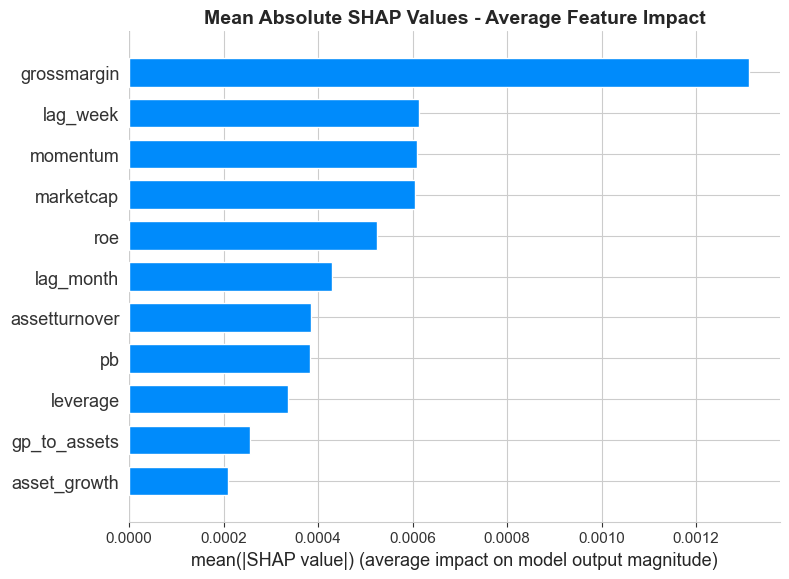

In [ ]:
# Bar plot showing mean absolute SHAP values
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, 
                  plot_type="bar", show=False)
plt.title('Mean Absolute SHAP Values - Average Feature Impact', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5. Explain Specific Predictions

Let's analyze the top predicted stocks to understand what drives high predictions.

In [ ]:
# Get top 5 and bottom 5 stocks
top_stocks = df.nlargest(5, 'predict')
bottom_stocks = df.nsmallest(5, 'predict')

print("TOP 5 PREDICTED STOCKS:")
print("="*80)
for idx, row in top_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")

print("\n" + "="*80)
print("\nBOTTOM 5 PREDICTED STOCKS:")
print("="*80)
for idx, row in bottom_stocks.iterrows():
    print(f"\n{row['ticker']} - Predicted Return: {row['predict']*100:.2f}%")
    print(f"  Sector: {row['sector']}, Size: {row['size']}")
    print(f"  Momentum: {row['momentum']*100:.2f}%, P/B: {row['pb']:.2f}, ROE: {row['roe']*100:.2f}%")

TOP 5 PREDICTED STOCKS:

IMA - Predicted Return: 15.68%
  Sector: Healthcare, Size: Micro-Cap
  Momentum: -61.46%, P/B: 0.60, ROE: -35.30%

CKX - Predicted Return: 14.82%
  Sector: Energy, Size: Micro-Cap
  Momentum: -11.89%, P/B: 1.10, ROE: 1.40%

SMLR - Predicted Return: 14.14%
  Sector: Healthcare, Size: Small-Cap
  Momentum: -57.98%, P/B: 0.60, ROE: 34.60%

MOVE - Predicted Return: 11.37%
  Sector: Healthcare, Size: Micro-Cap
  Momentum: -87.71%, P/B: -5.20, ROE: -288.40%

LYEL - Predicted Return: 7.88%
  Sector: Healthcare, Size: Small-Cap
  Momentum: -6.68%, P/B: 1.20, ROE: -65.90%


BOTTOM 5 PREDICTED STOCKS:

ENVB - Predicted Return: -13.70%
  Sector: Healthcare, Size: Nano-Cap
  Momentum: -87.32%, P/B: 1.00, ROE: -219.70%

SBDS - Predicted Return: -11.03%
  Sector: Consumer Cyclical, Size: Micro-Cap
  Momentum: -70.97%, P/B: 0.20, ROE: -58.40%

OESX - Predicted Return: -10.04%
  Sector: Industrials, Size: Micro-Cap
  Momentum: 12.88%, P/B: 4.60, ROE: -77.10%

FLGC - Predicted 


Explaining prediction for IMA (Top prediction)


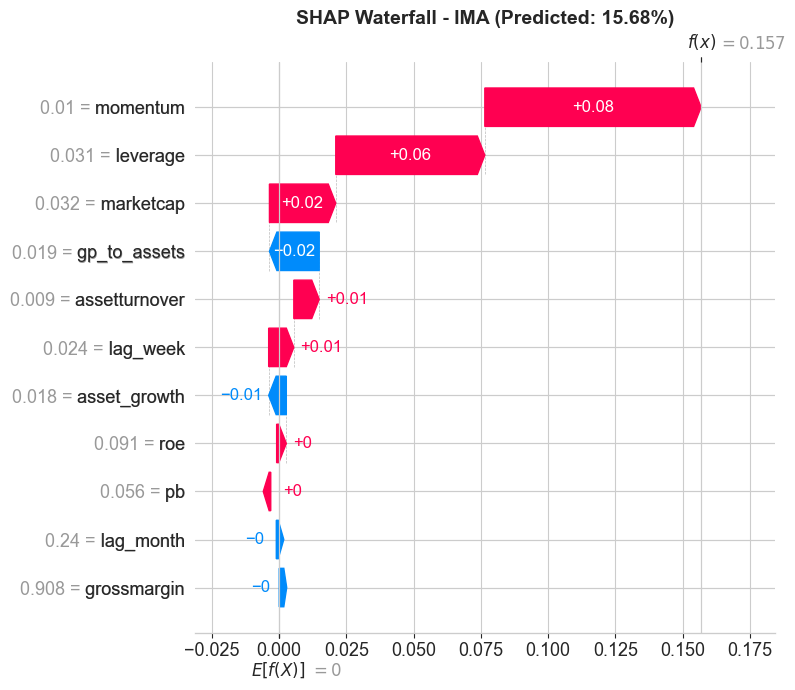

In [ ]:
# Calculate SHAP values for top stocks
top_indices = top_stocks.index.tolist()
X_top = X[top_indices]
shap_values_top = explainer.shap_values(X_top)

# Waterfall plot for the #1 predicted stock
print(f"\nExplaining prediction for {top_stocks.iloc[0]['ticker']} (Top prediction)")
shap.waterfall_plot(
    shap.Explanation(values=shap_values_top[0], 
                     base_values=explainer.expected_value,
                     data=X_top[0],
                     feature_names=feature_cols),
    max_display=12,
    show=False
)
plt.title(f"SHAP Waterfall - {top_stocks.iloc[0]['ticker']} (Predicted: {top_stocks.iloc[0]['predict']*100:.2f}%)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Waterfall Plot Interpretation:**
- Starts at the base value (average prediction across all stocks)
- Each feature pushes the prediction up (red) or down (blue)
- The final value is the actual prediction for this stock

In [ ]:
# Force plot for top 3 stocks
print("\nForce plots for top 3 predictions:")
print("(Shows how each feature contributes to pushing prediction above/below base value)\n")

shap.initjs()

for i in range(min(3, len(top_stocks))):
    ticker = top_stocks.iloc[i]['ticker']
    prediction = top_stocks.iloc[i]['predict']
    print(f"\n{i+1}. {ticker} - Predicted: {prediction*100:.2f}%")
    
    display(shap.force_plot(
        explainer.expected_value,
        shap_values_top[i],
        X_top[i],
        feature_names=feature_cols,
        matplotlib=False
    ))


Force plots for top 3 predictions:
(Shows how each feature contributes to pushing prediction above/below base value)




1. IMA - Predicted: 15.68%



2. CKX - Predicted: 14.82%



3. SMLR - Predicted: 14.14%


### 6. Compare Top vs Bottom Predictions

Let's compare the feature distributions between high and low predicted stocks.

In [ ]:
# Define top and bottom deciles
df['decile'] = pd.qcut(df['predict'], q=10, labels=range(1, 11))
top_decile = df[df['decile'] == 10].copy()
bottom_decile = df[df['decile'] == 1].copy()

print(f"Top decile (D10): {len(top_decile)} stocks")
print(f"Bottom decile (D1): {len(bottom_decile)} stocks")

# Compare key features
comparison_features = ['momentum', 'lagged_return', 'pb', 'roe', 
                       'asset_growth', 'grossmargin', 'leverage']

comparison = pd.DataFrame({
    'Feature': comparison_features,
    'Top_Decile_Mean': [top_decile[f].mean() for f in comparison_features],
    'Bottom_Decile_Mean': [bottom_decile[f].mean() for f in comparison_features],
})
comparison['Difference'] = comparison['Top_Decile_Mean'] - comparison['Bottom_Decile_Mean']

print("\nFeature Comparison: Top Decile vs Bottom Decile")
print(comparison.to_string(index=False))

ValueError: Bin edges must be unique: Index([   -0.1369959298636247, -0.0007063631871390409, -0.0004924781770069494,
       -0.0002177022199545803, -0.0001787420273086923, -0.0001787420273086923,
        6.052557222036359e-05,  0.0004649338067238908,   0.001501605286344766,
          0.00211115658342831,     0.1568139177485973],
      dtype='float64', name='predict').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, feature in enumerate(comparison_features[:9]):
    ax = axes[i]
    
    # Plot distributions
    ax.hist(bottom_decile[feature], bins=30, alpha=0.5, label='Bottom Decile (D1)', color='red')
    ax.hist(top_decile[feature], bins=30, alpha=0.5, label='Top Decile (D10)', color='green')
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.set_title(f'{feature}', fontweight='bold')

plt.suptitle('Feature Distributions: Top vs Bottom Decile', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 7. Feature Interaction Analysis

Let's examine how features interact with each other.

In [ ]:
# Plot prediction vs key features
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

key_features = ['momentum', 'lagged_return', 'pb', 'roe', 'asset_growth', 'grossmargin']

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Scatter plot with trend line
    ax.scatter(df[feature], df['predict'], alpha=0.3, s=10)
    
    # Add trend line
    z = np.polyfit(df[feature], df['predict'], 1)
    p = np.poly1d(z)
    ax.plot(df[feature], p(df[feature]), "r--", linewidth=2, label='Trend')
    
    ax.set_xlabel(feature, fontweight='bold')
    ax.set_ylabel('Predicted Return', fontweight='bold')
    ax.set_title(f'Prediction vs {feature}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Relationships with Predictions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 8. SHAP Dependence Plots

Shows how a single feature affects predictions, accounting for interactions.

In [ ]:
# Get top 3 most important features
top_3_features = importance['feature'].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(top_3_features):
    feature_idx = feature_cols.index(feature)
    
    plt.sca(axes[i])
    shap.dependence_plot(
        feature_idx,
        shap_values,
        X_sample,
        feature_names=feature_cols,
        show=False
    )
    axes[i].set_title(f'SHAP Dependence: {feature}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Dependence Plot Interpretation:**
- X-axis: Feature value (percentile rank)
- Y-axis: SHAP value (impact on prediction)
- Color: Interaction with another feature
- Shows non-linear relationships and interactions

### 9. Sector and Size Analysis

Let's see if certain sectors or size groups have systematically different predictions.

In [ ]:
# Predictions by sector
sector_stats = df.groupby('sector')['predict'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
sector_stats.columns = ['Mean Prediction', 'Median Prediction', 'Count']

print("Predictions by Sector:")
print(sector_stats)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sector
sector_stats['Mean Prediction'].plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Mean Predicted Return', fontweight='bold')
ax1.set_title('Average Prediction by Sector', fontsize=14, fontweight='bold')
ax1.axvline(x=df['predict'].mean(), color='red', linestyle='--', label='Overall Mean')
ax1.legend()

# Size
size_stats = df.groupby('size')['predict'].mean().sort_values(ascending=False)
size_stats.plot(kind='barh', ax=ax2, color='coral')
ax2.set_xlabel('Mean Predicted Return', fontweight='bold')
ax2.set_title('Average Prediction by Size', fontsize=14, fontweight='bold')
ax2.axvline(x=df['predict'].mean(), color='red', linestyle='--', label='Overall Mean')
ax2.legend()

plt.tight_layout()
plt.show()

### 10. Summary and Key Insights

In [ ]:
print("="*80)print("KEY INSIGHTS FROM MODEL EXPLAINABILITY ANALYSIS")print("="*80)print("\n1. MOST IMPORTANT FEATURES (by model):")for i, row in importance.head(5).iterrows():    print(f"   {row['feature']}: {row['importance']:.1f}")print("\n2. TOP PREDICTED STOCKS:")for i, row in top_stocks.head(3).iterrows():    print(f"   {row['ticker']}: {row['predict']*100:.2f}% - {row['sector']}, {row['size']}")print("\n3. FEATURE CHARACTERISTICS OF TOP DECILE:")top_characteristics = comparison.nlargest(3, 'Difference')for i, row in top_characteristics.iterrows():    direction = "higher" if row['Difference'] > 0 else "lower"    print(f"   {row['Feature']}: {direction} by {abs(row['Difference']):.4f}")print("\n4. PREDICTION DISTRIBUTION:")print(f"   Mean: {df['predict'].mean()*100:.2f}%")print(f"   Median: {df['predict'].median()*100:.2f}%")print(f"   Std Dev: {df['predict'].std()*100:.2f}%")print(f"   Range: {df['predict'].min()*100:.2f}% to {df['predict'].max()*100:.2f}%")print("\n5. BEST PERFORMING SECTORS (by average prediction):")for sector, mean_pred in sector_stats.head(3)['Mean Prediction'].items():    print(f"   {sector}: {mean_pred*100:.2f}%")print("\n" + "="*80)print("INTERPRETATION:")print("="*80)print("""The model's predictions are primarily driven by:- Recent momentum and past returns (lagged_return, momentum)- Valuation metrics (P/B ratio, ROE)- Growth indicators (asset_growth, margins)Stocks with high predicted returns typically exhibit:- Strong recent momentum- Favorable valuation characteristics- Better profitability metricsThe SHAP analysis reveals that the model uses non-linear relationshipsand interactions between features, which helps explain why simplecorrelations don't fully capture the prediction logic.""")print("="*80)

### 11. Export Detailed Analysis

In [ ]:
# Create detailed export with SHAP values for top/bottom stocks
# Calculate SHAP for top and bottom 20
top_20 = df.nlargest(20, 'predict')
bottom_20 = df.nsmallest(20, 'predict')
analysis_stocks = pd.concat([top_20, bottom_20])

X_analysis = X[analysis_stocks.index]
shap_values_analysis = explainer.shap_values(X_analysis)

# Create DataFrame with SHAP contributions
shap_df = pd.DataFrame(shap_values_analysis, columns=[f'shap_{col}' for col in feature_cols])
shap_df.index = analysis_stocks.index

# Combine with original data
export_df = pd.concat([analysis_stocks, shap_df], axis=1)
export_df['base_value'] = explainer.expected_value

# Save to Excel
export_df.to_excel('model_explanation_details.xlsx', index=False)
print("\nDetailed analysis exported to: model_explanation_details.xlsx")
print(f"Includes {len(export_df)} stocks with SHAP value breakdowns")